# 1. Mutation Indicator with SKLearn Models

---
#### 7. Model Training
<a id="training"></a>

##### 7.1 Ensemble of sklearn models on flat data (baseline on sparse samples)
<a id="sklearn"></a>

In [86]:
# sklearn
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [98]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          name=None,
                          cmap=plt.cm.Blues,
                          savefig=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
            
    title = 'Confusion Matrices'

    # Compute confusion matrices
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            
    # Initialise plot
    fig, axes = plt.subplots(ncols=2, figsize = (20,11))
    fig.suptitle(title)
    plt.subplots_adjust(hspace=0.6)

    for i, ax in enumerate(axes):
        if i == 1:
            normalise = True
            data = cm_norm
            title = 'Normalised'
        else:
            normalise = False
            data = cm
            title = 'Non-Normalised'
            
        ax.imshow(data, interpolation='nearest')
        
#         ax.figure.colorbar()
        # We want to show all ticks...
        ax.set(xticks=np.arange(data.shape[1]),
               yticks=np.arange(data.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.1f' if normalise else 'd'
        thresh = data.max() / 2.
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                ax.text(j, i, format(data[i, j], fmt),
                        ha="center", va="center",
                        color="white" if data[i, j] < thresh else "black")
            
    fig.tight_layout()
    plt.show()
    
    if savefig:
        fig.savefig(FIGURES + '/sklearn/' + name.lower().replace(' ','_'), dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)
    

# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    
    cv_proba = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  method='predict_proba',
                                                  n_jobs=-1)
    
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, acc_cv, cv_proba

In [99]:
# Gradient Boosting Trees
def run_model(X_train, y_train, model, model_name, data_name, cv=10):
    start_time = time.time()
    train_pred, acc_cv, cv_proba = fit_ml_algo(model, 
                                             X_train, 
                                             y_train, 
                                             cv)
    gbt_time = (time.time() - start_time)
    
    print("Model: %s, DataFrame: %s" % (model_name, data_name))
    print("Accuracy CV 10-Fold: %s" % acc_cv)
    print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))
    
    print(metrics.classification_report(y_train, train_pred))
    
    save_dir = EXP1_DIR + "{}_{}_".format(data_name, model_name)
    
    # save model
    with open(save_dir + "model.pkl", 'wb') as outfile:
        pkl.dump(model, outfile)
    
    # save scores
    with open(save_dir + "scores.pkl", 'wb') as outfile:
        pkl.dump((train_pred, acc_cv, cv_proba), outfile)
    
    return train_pred, acc_cv, cv_proba

In [100]:
models2 = {
        'log' : {
            'model' : LogisticRegression(n_jobs = -1),
        },
        
        'knn' : {
            'model' : KNeighborsClassifier(n_neighbors = 3,
                                           n_jobs = -1)
        },
    
        'gaussian' : {
            'model' : GaussianNB()   
        },
    
        'sgd' : {
            'model' : CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge', 
                                                                          max_iter=1, 
                                                                          n_jobs = -1), 
                                             method='sigmoid', 
                                             cv=10)
        },
    
        'dt' : {
            'model' : DecisionTreeClassifier()
        },
    
        'rf' : {
            'model' : RandomForestClassifier(n_estimators=10, 
                                             min_samples_leaf=2,
                                             min_samples_split=17, 
                                             criterion='gini', 
                                             max_features=8)
        },
    
        'gbt' : { 
            'model' : GradientBoostingClassifier(n_estimators=20, 
                                                 min_samples_leaf=2,
                                                 min_samples_split=17, 
                                                 max_features=20)
        }
    }

/home/athon/.conda/envs/thesis/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: log, DataFrame: df_1
Accuracy CV 10-Fold: 48.78
Running Time: 0:00:05.331216
                precision    recall  f1-score   support

MERGE-COADREAD       0.73      0.77      0.75       534
  MERGE-GBMLGG       0.64      0.72      0.68       876
    MERGE-STES       0.26      0.22      0.24       613
      TCGA-ACC       0.38      0.07      0.11        75
     TCGA-BLCA       0.57      0.51      0.54       409
     TCGA-BRCA       0.42      0.65      0.51       961
     TCGA-CESC       0.28      0.20      0.23       286
     TCGA-CHOL       0.27      0.06      0.10        48
     TCGA-DLBC       0.58      0.19      0.29        37
     TCGA-HNSC       0.38      0.37      0.37       502
     TCGA-KICH       0.00      0.00      0.00        51
     TCGA-KIRC       0.74      0.71      0.73       324
     TCGA-KIRP       0.22      0.19      0.21       254
     TCGA-LAML       0.65      0.43      0.52       127
     TCGA-LIHC       0.39      0.33      0.35       353
     TCGA-LUAD     

/home/athon/.conda/envs/thesis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


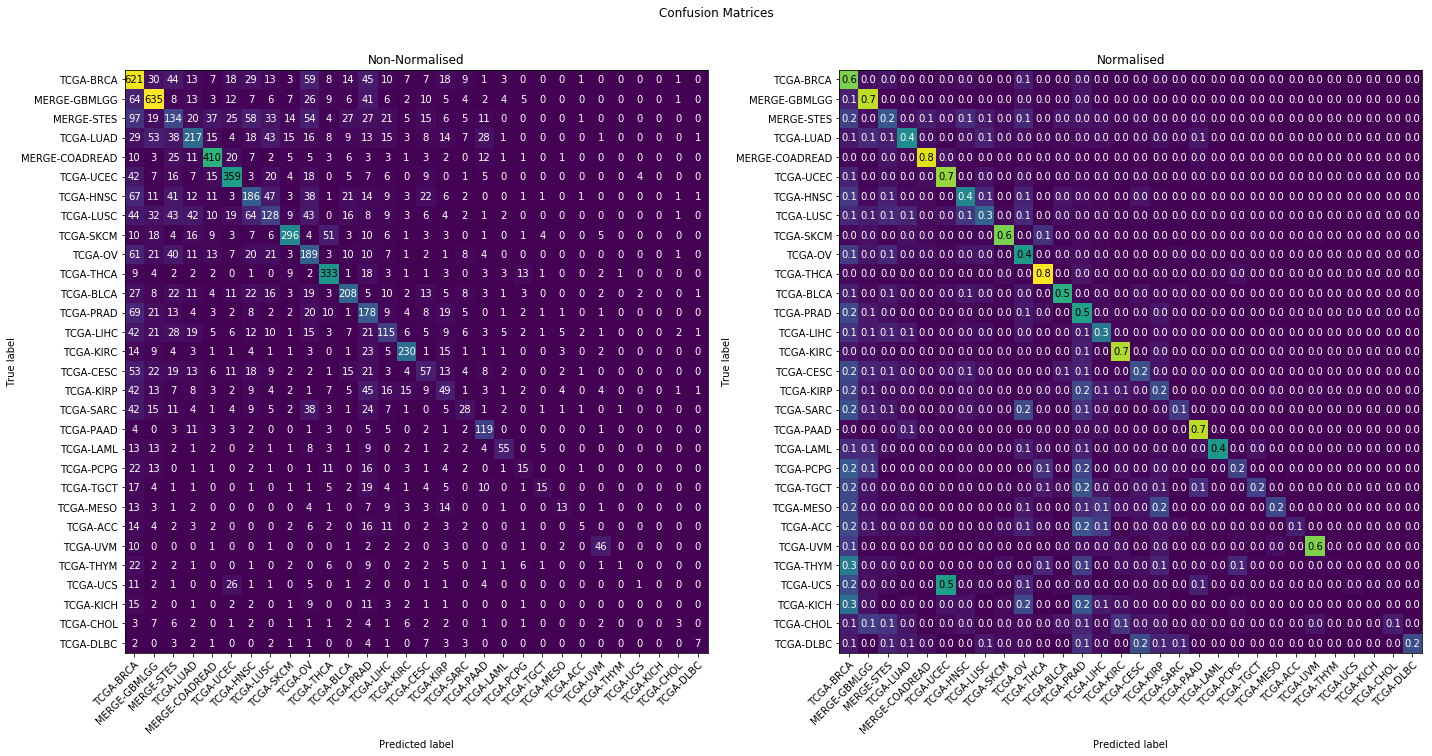

/home/athon/.conda/envs/thesis/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: knn, DataFrame: df_1
Accuracy CV 10-Fold: 31.62
Running Time: 0:00:17.410473
                precision    recall  f1-score   support

MERGE-COADREAD       0.65      0.63      0.64       534
  MERGE-GBMLGG       0.31      0.76      0.44       876
    MERGE-STES       0.14      0.13      0.13       613
      TCGA-ACC       0.08      0.11      0.09        75
     TCGA-BLCA       0.34      0.12      0.18       409
     TCGA-BRCA       0.31      0.49      0.38       961
     TCGA-CESC       0.13      0.07      0.09       286
     TCGA-CHOL       0.02      0.04      0.03        48
     TCGA-DLBC       0.00      0.00      0.00        37
     TCGA-HNSC       0.25      0.12      0.17       502
     TCGA-KICH       0.03      0.04      0.04        51
     TCGA-KIRC       0.50      0.51      0.51       324
     TCGA-KIRP       0.10      0.11      0.10       254
     TCGA-LAML       0.22      0.38      0.28       127
     TCGA-LIHC       0.17      0.06      0.09       353
     TCGA-LUAD     

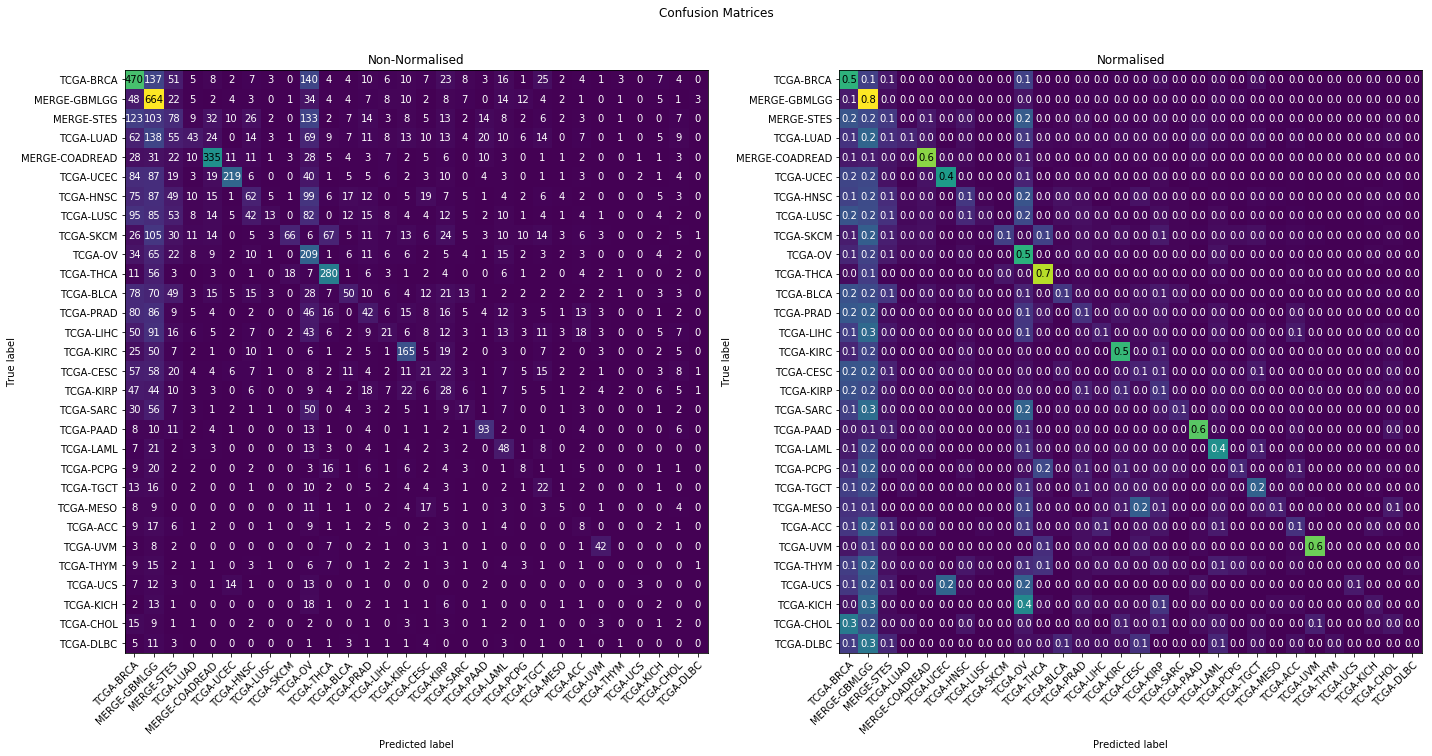

/home/athon/.conda/envs/thesis/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: gaussian, DataFrame: df_1
Accuracy CV 10-Fold: 9.06
Running Time: 0:00:00.937451
                precision    recall  f1-score   support

MERGE-COADREAD       0.08      0.02      0.03       534
  MERGE-GBMLGG       0.27      0.01      0.02       876
    MERGE-STES       0.06      0.00      0.01       613
      TCGA-ACC       0.02      0.11      0.03        75
     TCGA-BLCA       0.48      0.19      0.28       409
     TCGA-BRCA       0.50      0.02      0.05       961
     TCGA-CESC       0.08      0.10      0.09       286
     TCGA-CHOL       0.02      0.17      0.04        48
     TCGA-DLBC       0.01      0.08      0.02        37
     TCGA-HNSC       0.27      0.04      0.07       502
     TCGA-KICH       0.03      0.20      0.05        51
     TCGA-KIRC       0.14      0.23      0.17       324
     TCGA-KIRP       0.04      0.11      0.06       254
     TCGA-LAML       0.10      0.31      0.15       127
     TCGA-LIHC       0.06      0.07      0.06       353
     TCGA-LUAD 

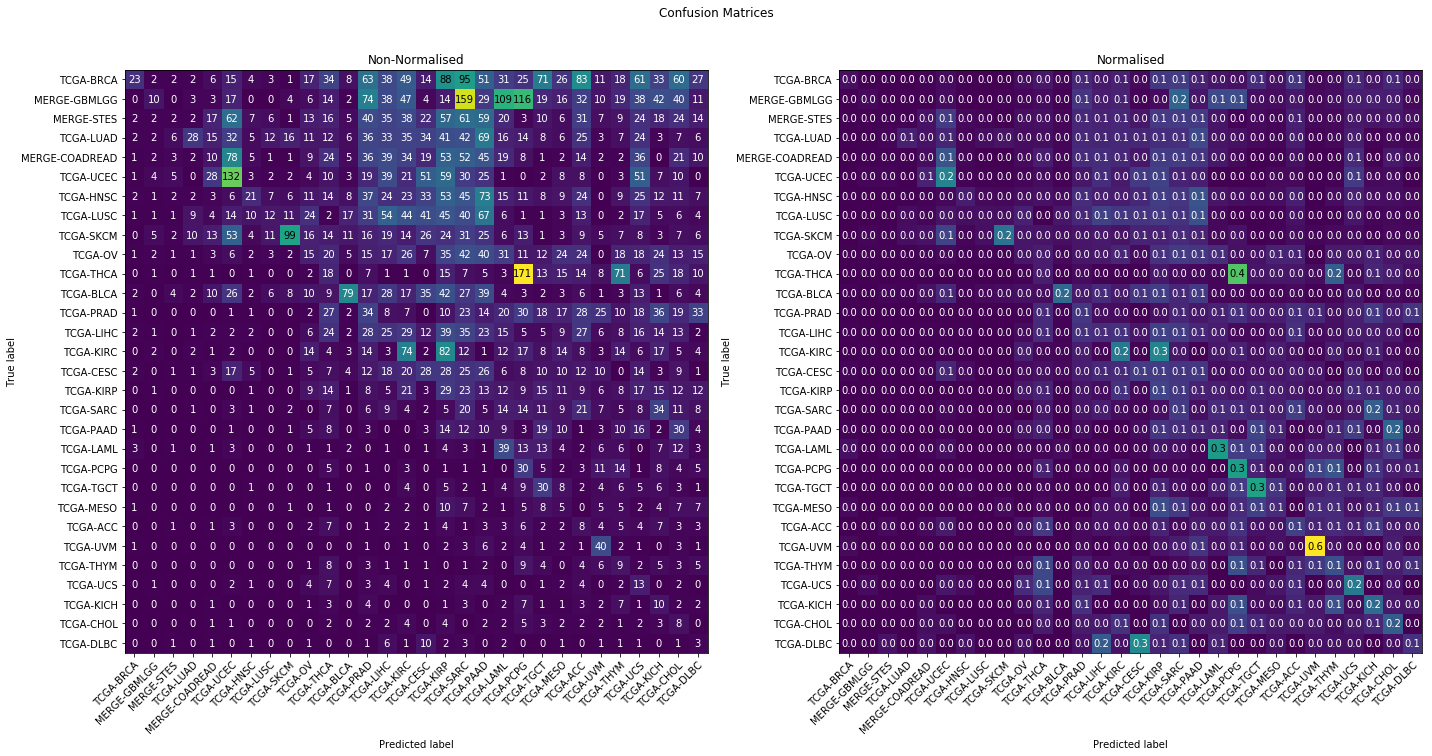

/home/athon/.conda/envs/thesis/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: sgd, DataFrame: df_1
Accuracy CV 10-Fold: 46.4
Running Time: 0:00:08.992628
                precision    recall  f1-score   support

MERGE-COADREAD       0.64      0.78      0.70       534
  MERGE-GBMLGG       0.55      0.71      0.62       876
    MERGE-STES       0.25      0.12      0.16       613
      TCGA-ACC       0.00      0.00      0.00        75
     TCGA-BLCA       0.53      0.56      0.54       409
     TCGA-BRCA       0.28      0.77      0.41       961
     TCGA-CESC       0.43      0.03      0.06       286
     TCGA-CHOL       0.00      0.00      0.00        48
     TCGA-DLBC       1.00      0.08      0.15        37
     TCGA-HNSC       0.40      0.39      0.39       502
     TCGA-KICH       0.00      0.00      0.00        51
     TCGA-KIRC       0.75      0.69      0.72       324
     TCGA-KIRP       0.40      0.07      0.11       254
     TCGA-LAML       0.81      0.24      0.37       127
     TCGA-LIHC       0.51      0.29      0.37       353
     TCGA-LUAD      

/home/athon/.conda/envs/thesis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


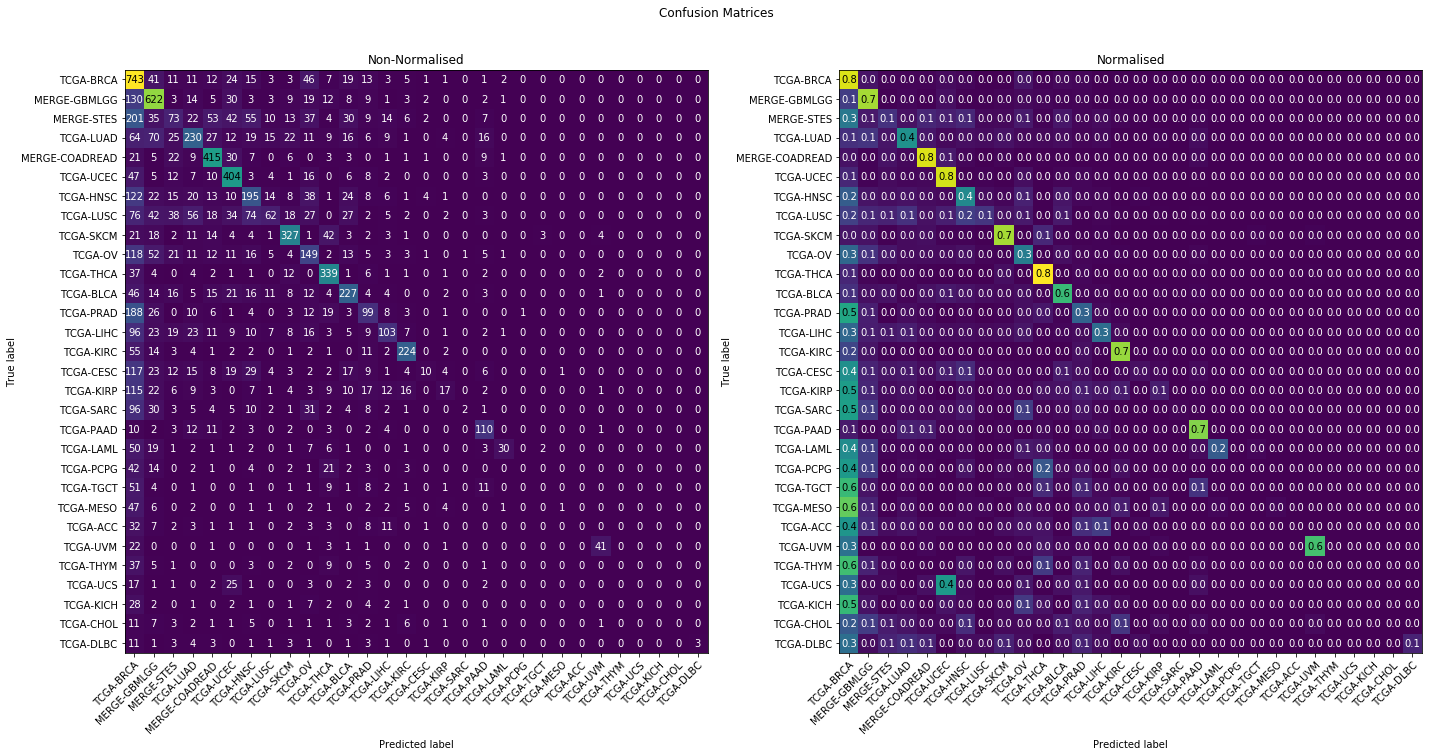

/home/athon/.conda/envs/thesis/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: dt, DataFrame: df_1
Accuracy CV 10-Fold: 39.27
Running Time: 0:00:04.823097
                precision    recall  f1-score   support

MERGE-COADREAD       0.65      0.64      0.65       534
  MERGE-GBMLGG       0.57      0.68      0.62       876
    MERGE-STES       0.17      0.15      0.16       613
      TCGA-ACC       0.09      0.16      0.11        75
     TCGA-BLCA       0.36      0.25      0.29       409
     TCGA-BRCA       0.42      0.50      0.46       961
     TCGA-CESC       0.19      0.17      0.18       286
     TCGA-CHOL       0.05      0.08      0.06        48
     TCGA-DLBC       0.00      0.00      0.00        37
     TCGA-HNSC       0.28      0.24      0.26       502
     TCGA-KICH       0.02      0.04      0.03        51
     TCGA-KIRC       0.68      0.63      0.65       324
     TCGA-KIRP       0.14      0.11      0.12       254
     TCGA-LAML       0.31      0.38      0.34       127
     TCGA-LIHC       0.24      0.17      0.20       353
     TCGA-LUAD      

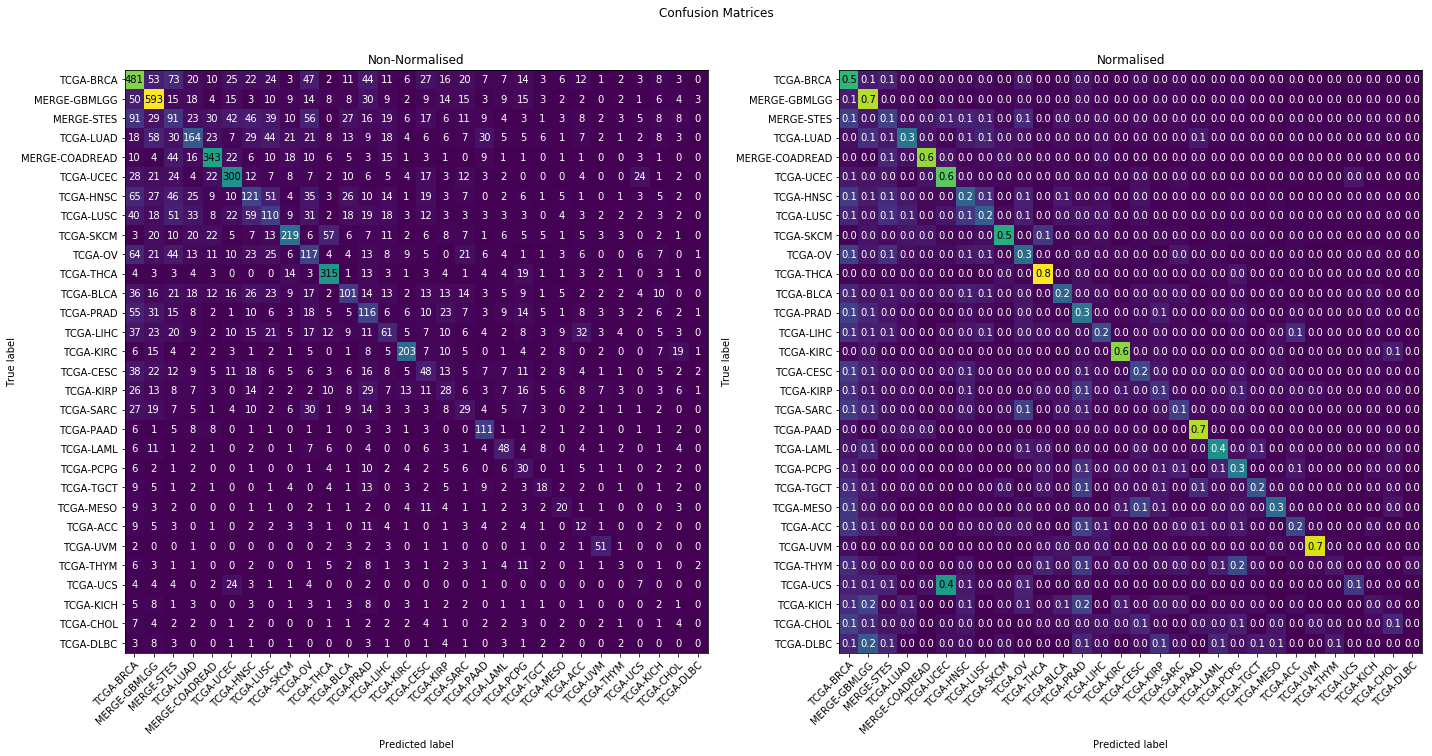

/home/athon/.conda/envs/thesis/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: rf, DataFrame: df_1
Accuracy CV 10-Fold: 45.85
Running Time: 0:00:00.969622
                precision    recall  f1-score   support

MERGE-COADREAD       0.63      0.76      0.69       534
  MERGE-GBMLGG       0.54      0.74      0.62       876
    MERGE-STES       0.19      0.12      0.15       613
      TCGA-ACC       0.38      0.04      0.07        75
     TCGA-BLCA       0.46      0.40      0.43       409
     TCGA-BRCA       0.43      0.63      0.51       961
     TCGA-CESC       0.23      0.08      0.12       286
     TCGA-CHOL       0.33      0.02      0.04        48
     TCGA-DLBC       0.25      0.03      0.05        37
     TCGA-HNSC       0.37      0.34      0.35       502
     TCGA-KICH       0.00      0.00      0.00        51
     TCGA-KIRC       0.66      0.73      0.69       324
     TCGA-KIRP       0.26      0.17      0.21       254
     TCGA-LAML       0.53      0.34      0.41       127
     TCGA-LIHC       0.44      0.27      0.34       353
     TCGA-LUAD      

/home/athon/.conda/envs/thesis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


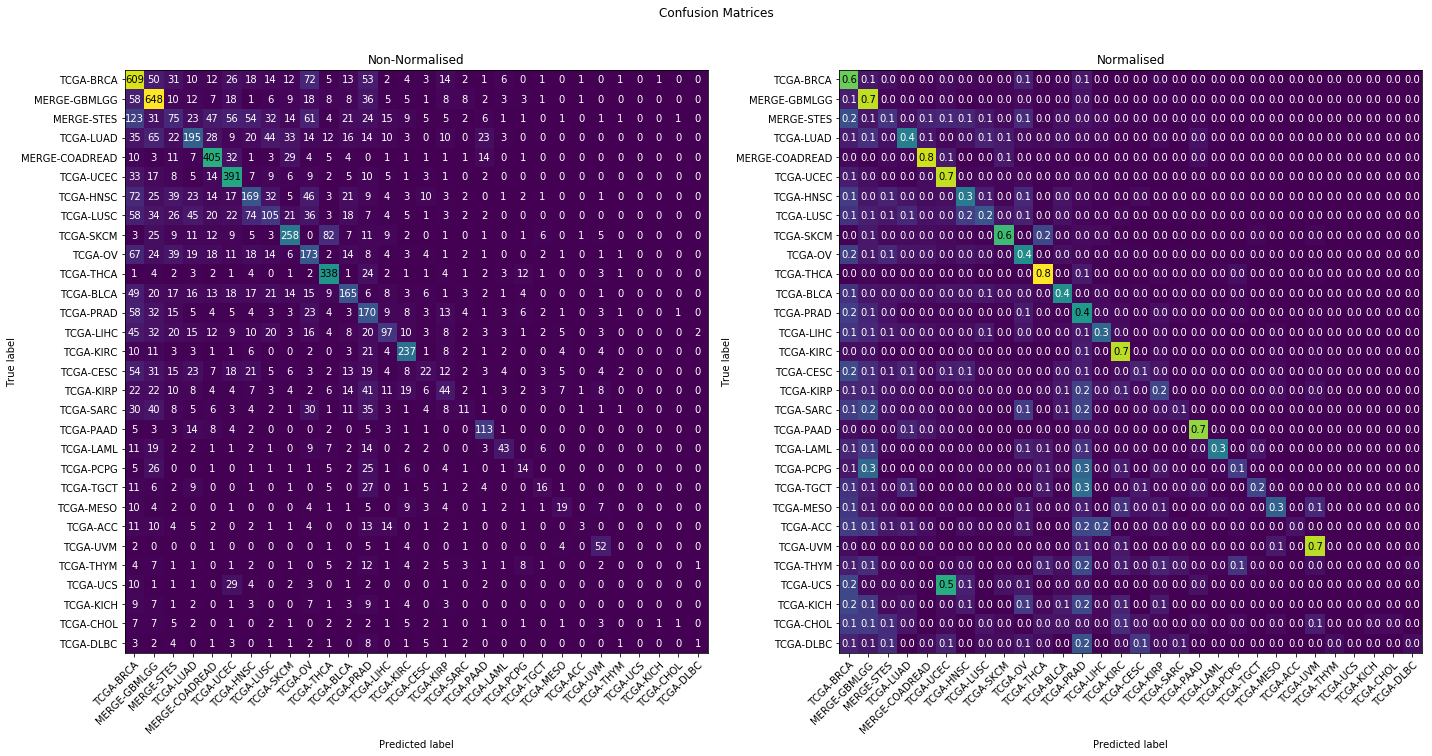

/home/athon/.conda/envs/thesis/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: gbt, DataFrame: df_1
Accuracy CV 10-Fold: 39.81
Running Time: 0:00:14.134079
                precision    recall  f1-score   support

MERGE-COADREAD       0.59      0.74      0.65       534
  MERGE-GBMLGG       0.42      0.71      0.53       876
    MERGE-STES       0.23      0.10      0.14       613
      TCGA-ACC       0.67      0.03      0.05        75
     TCGA-BLCA       0.53      0.39      0.45       409
     TCGA-BRCA       0.22      0.80      0.35       961
     TCGA-CESC       0.24      0.02      0.03       286
     TCGA-CHOL       0.00      0.00      0.00        48
     TCGA-DLBC       0.50      0.05      0.10        37
     TCGA-HNSC       0.36      0.29      0.32       502
     TCGA-KICH       0.00      0.00      0.00        51
     TCGA-KIRC       0.78      0.64      0.70       324
     TCGA-KIRP       0.42      0.04      0.08       254
     TCGA-LAML       0.68      0.20      0.30       127
     TCGA-LIHC       0.54      0.18      0.27       353
     TCGA-LUAD     

/home/athon/.conda/envs/thesis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


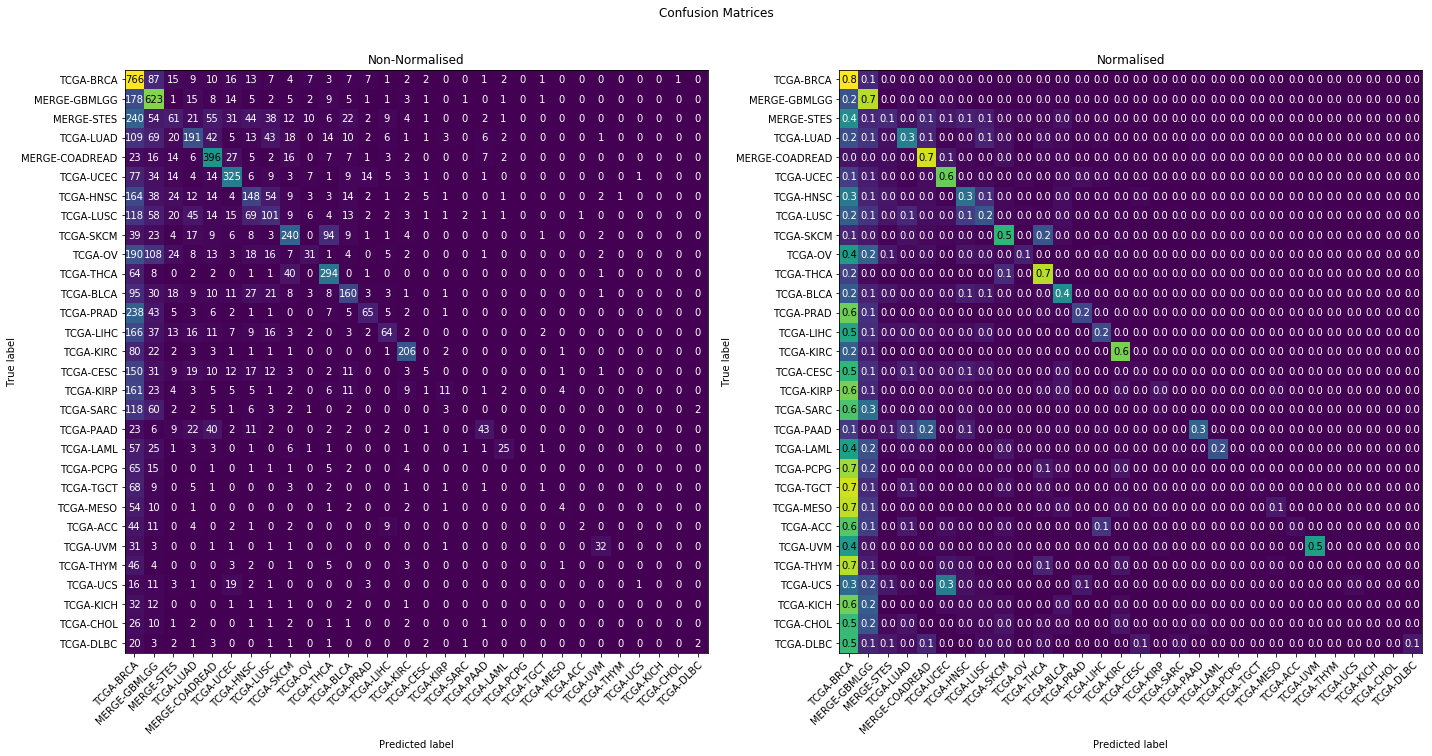

In [102]:
for name, model in models2.items():
    model['train_pred'], model['acc_cv'], model['cv_proba'] = run_model(df_X1, df_y1, model['model'], name, 'df_1')
    plot_confusion_matrix(df_y1, 
                          model['train_pred'], 
                          classes=df_y1['project_short_name'].value_counts().index.values,
                          name=name)

Grid plot of normalised confusion matrices

In [ ]:
fig = plt.figure(figsize=(12,8)); title = 'Distribution of Mutation Indices by Occurrence'
ax = tcga_raw['Start_Position'].value_counts().plot(kind='hist', log=True,bins=20)
ax.set_title(title); ax.set_xlabel('Mutation Index Co-occurrence')
fig.savefig(FIGURES + title.lower().replace(' ','_'), dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)

Text(0.5, 1.0, 'Traditional ML Classifiers with Gene Mutation Indicators')

Text(0.5, 0, 'Classifier Type')

Text(0, 0.5, 'Accuracy CV (%)')

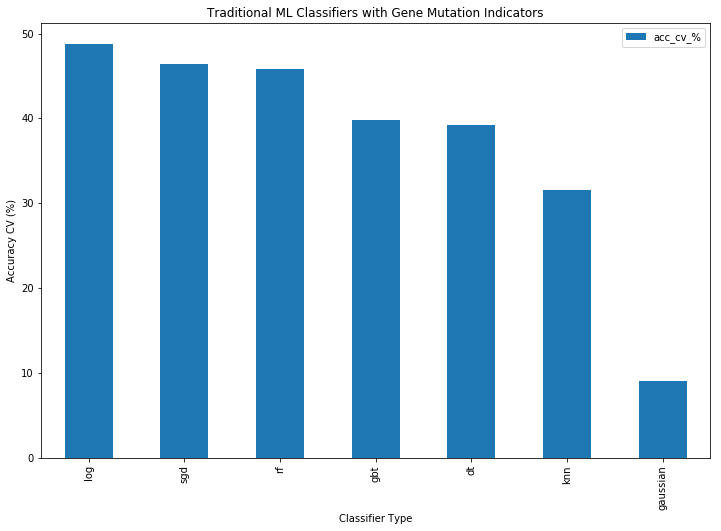

In [123]:
results_dict = {'model_name':[], 'acc_cv_%':[]}
for name, model in models2.items():
    results_dict['model_name'].append(name)
    results_dict['acc_cv_%'].append(model['acc_cv'])

results_df = pd.DataFrame(results_dict)
fig, ax = plt.subplots(1, 1, figsize=(12,8)); title = 'Traditional ML Classifiers with Gene Mutation Indicators';
results_df.sort_values('acc_cv_%', ascending=False)\
                .set_index('model_name').plot(kind='bar', ax=ax)
ax.set_title(title); ax.set_xlabel('Classifier Type'); ax.set_ylabel('Accuracy CV (%)')
fig.savefig(FIGURES + title.lower().replace(' ','_'), dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)